# Adaptive RK4 Orbits

We'll use the same basic ideas in our fixed timestep RK4 integrator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# global parameters
GM = 4.0 * np.pi**2  # assuming M = 1 solar mass

The `OrbitState` class is unchanged.

In [3]:
class OrbitState:
    # a container to hold the star positions
    def __init__(self, x, y, u, v):
        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __add__(self, other):
        return OrbitState(self.x + other.x, self.y + other.y,
                          self.u + other.u, self.v + other.v)

    def __sub__(self, other):
        return OrbitState(self.x - other.x, self.y - other.y,
                          self.u - other.u, self.v - other.v)

    def __mul__(self, other):
        return OrbitState(other * self.x, other * self.y,
                          other * self.u, other * self.v)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __str__(self):
        return f"{self.x:10.6f} {self.y:10.6f} {self.u:10.6f} {self.v:10.6f}"

Now the integrator class

In [4]:
class OrbitsRK4:
    """ model the evolution of a single planet around the Sun"""

    def __init__(self, a, e):
        """ a = semi-major axis (in AU),
            e = eccentricity """

        self.a = a
        self.e = e

        x0 = 0.0          # start at x = 0 by definition
        y0 = a*(1.0 - e)  # start at perihelion

        # perihelion velocity (see C&O Eq. 2.33 for ex)
        u0 = -np.sqrt( (GM/a)* (1.0 + e) / (1.0 - e) )
        v0 = 0.0

        self.history = [OrbitState(x0, y0, u0, v0)]
        self.time = [0.0]

        self.n_reset = None

    def kepler_period(self):
        """ return the period of the orbit in yr """
        return np.sqrt(self.a**3)

    def energy(self, n):
        """ return the energy (per unit mass) at time n """

        state = self.history[n]
        return 0.5 * (state.u**2 + state.v**2) - \
            GM / np.sqrt(state.x**2 + state.y**2)

    def rhs(self, state):
        """ RHS of the equations of motion."""

        # current radius
        r = np.sqrt(state.x**2 + state.y**2)

        # position
        xdot = state.u
        ydot = state.v

        # velocity
        udot = -GM * state.x / r**3
        vdot = -GM * state.y / r**3

        return OrbitState(xdot, ydot, udot, vdot)

    def single_step(self, state_old, dt):
        """ take a single RK-4 timestep from t to t+dt for the system
        ydot = rhs """

        # get the RHS at several points
        ydot1 = self.rhs(state_old)

        state_tmp = state_old + 0.5 * dt * ydot1
        ydot2 = self.rhs(state_tmp)

        state_tmp = state_old + 0.5 * dt * ydot2
        ydot3 = self.rhs(state_tmp)

        state_tmp = state_old + dt * ydot3
        ydot4 = self.rhs(state_tmp)

        # advance
        state_new = state_old + (dt / 6.0) * (ydot1 + 2.0 * ydot2 +
                                              2.0 * ydot3 + ydot4)

        return state_new

    def integrate(self, dt_in, err, tmax):
        """ integrate the equations of motion using 4th order R-K method with an
            adaptive stepsize, to try to achieve the relative error err.  dt
            here is the initial timestep
            """

        # start with the old timestep
        dt_new = dt_in
        dt = dt_in

        n_reset = 0
        t = 0

        while t < tmax:
            
            state_old = self.history[-1]

            if err > 0.0:

                # adaptive stepping iteration loop -- keep trying to take a step
                # until we achieve our desired error

                rel_error = 1.e10

                n_try = 0
                while rel_error > err:
                    dt = min(dt_new, tmax-t)

                    # take 2 half steps
                    state_tmp = self.single_step(state_old, 0.5*dt)
                    state_new = self.single_step(state_tmp, 0.5*dt)

                    # now take just a single step to cover dt
                    state_single = self.single_step(state_old, dt)

                    # state_new should be more accurate than state_single since it
                    # used smaller steps

                    # estimate the relative error now

                    rel_error = max(abs((state_new.x - state_single.x) / state_single.x),
                                    abs((state_new.y - state_single.y) / state_single.y),
                                    abs((state_new.u - state_single.u) / state_single.u),
                                    abs((state_new.v - state_single.v) / state_single.v))

                    # adaptive timestep algorithm for RK4

                    dt_est = dt * abs(err/rel_error)**0.2
                    dt_new = min(max(0.9 * dt_est, 0.25 * dt), 4.0 * dt)

                    n_try += 1

                if n_try > 1:
                    # n_try = 1 if we took only a single try at the step
                    n_reset += (n_try-1)

            else:

                # take just a single step
                dt = min(dt_new, tmax-t)

                # take just a single step to cover dt
                state_new = self.single_step(state_old, dt)

            # successful step
            t += dt

            # store
            self.time.append(t)
            self.history.append(state_new)

    def plot(self, points=False):
        """plot the orbit"""
        fig, ax = plt.subplots()
        x = [q.x for q in self.history]
        y = [q.y for q in self.history]

        # draw the Sun
        ax.scatter([0], [0], marker=(20, 1), color="y", s=250)

        if points:
            ax.scatter(x, y, marker=".")
        else:
            ax.plot(x, y)
        ax.set_aspect("equal")
        return fig

## Highly eccentric orbit

Let's create an orbit with a tolerance of $10^{-5}$, and the a very high eccentricity ($a = 1$, $e = 0.95$)

In [5]:
o = OrbitsRK4(1.0, 0.95)
o.integrate(0.05, 1.e-5, o.kepler_period())

How many points did it take?

In [6]:
len(o.history)

92

Let's plot it

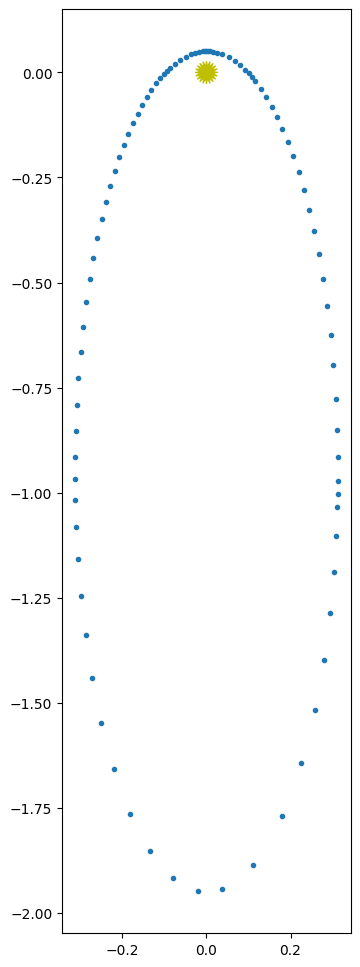

In [7]:
fig = o.plot(points=True)
fig.set_size_inches(5, 12)

Clearly we see that the size of the timestep is much larger at aphelion as compared to perihelion.

Let's create a version with a fixed timestep, with a timestep of $0.001~\mathrm{yr}$.  We can do this by passing in a negative error.

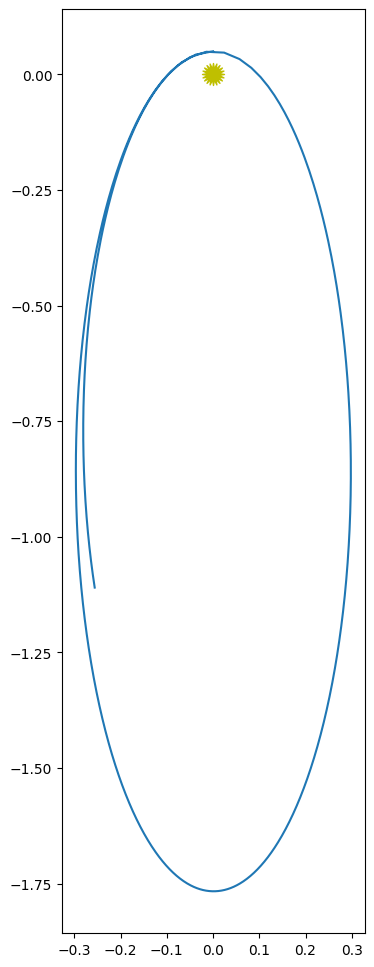

In [8]:
o_fixed = OrbitsRK4(1.0, 0.95)
o_fixed.integrate(0.001, -1, o_fixed.kepler_period())
fig = o_fixed.plot()
fig.set_size_inches(5, 12)

In [9]:
len(o_fixed.history)

1001

We need a really small fixed step size to integrate this at all reasonably

## Timestep evolution

Let's look at the adaptive version some more.  First, let's look at the timestep evolution.

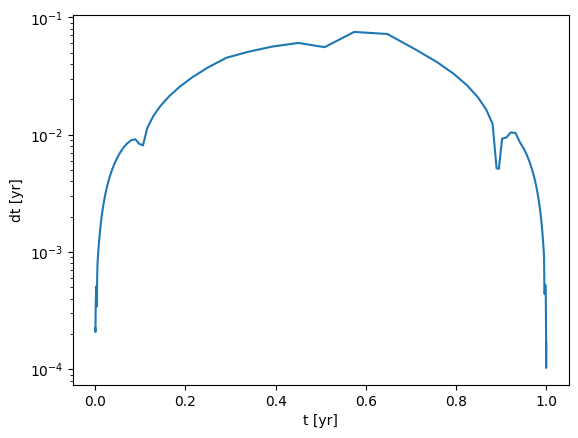

In [10]:
ts = np.array(o.time)

dt = ts[1:] - ts[:-1]
tc = 0.5 * (ts[1:] + ts[:-1])

fig, ax = plt.subplots()
ax.plot(tc, dt)
ax.set_xlabel("t [yr]")
ax.set_ylabel("dt [yr]")
ax.set_yscale("log")

Notice that the timestep changes by ~ 3 orders of magnitude over the evolution.

## Energy conservation

What about energy conservation?

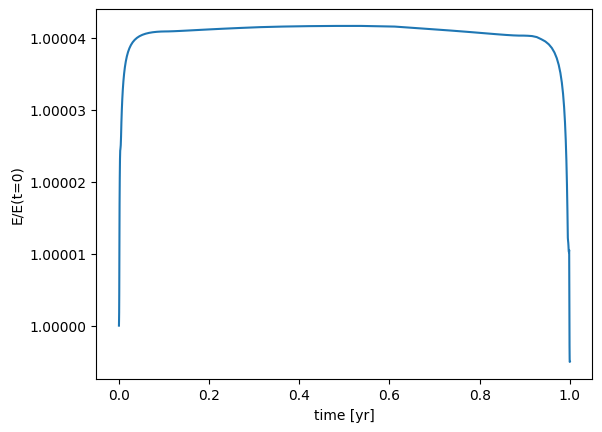

In [11]:
e = []
ts = o.time
for n in range(len(o.history)):
    e.append(o.energy(n))
    
fig, ax = plt.subplots()
ax.plot(ts, e/e[0])
ax.set_xlabel("time [yr]")
ax.set_ylabel("E/E(t=0)")
ax.ticklabel_format(useOffset=False)

Now let's do 10 orbits

In [12]:
o = OrbitsRK4(1.0, 0.95)
o.integrate(0.05, 1.e-5, 20*o.kepler_period())

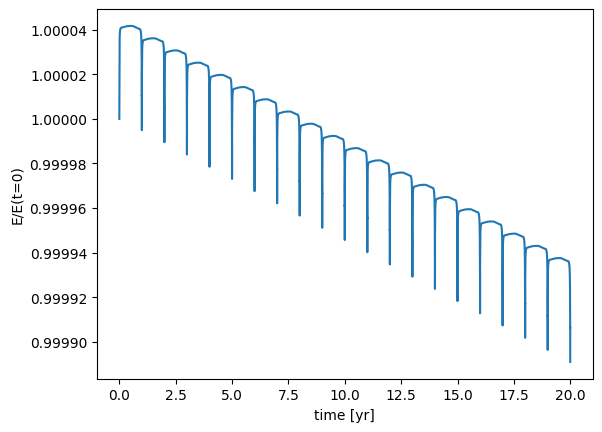

In [13]:
e = []
ts = o.time
for n in range(len(o.history)):
    e.append(o.energy(n))
    
fig, ax = plt.subplots()
ax.plot(ts, e/e[0])
ax.set_xlabel("time [yr]")
ax.set_ylabel("E/E(t=0)")
ax.ticklabel_format(useOffset=False)

```{caution}
We can see that RK4 does not conserve energy!
```

There is a steady decrease in the total energy over 20 orbits.  If we wanted to evolve for millions of years, this would certainly be a problem.  Making the tolerance tighter certainly will help, but it will also make things a lot more expensive.

The problem is that 4th order Runge-Kutta does not know anything about energy conservation.